# VAE with the CIFAR100 dataset
Training of a VAE on the Cifar100 dataset. VAR inspired by [link](https://github.com/henryqin1997/vae-cifar10/blob/master/cifar10_vae.py)

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, utils, models
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup 
import numpy as np
from torch import optim
import os
from os.path import exists


## !! For Checkpointing!!!

# Path to saving the model
save_model_path = "../../trainedModels/VAE_CIFAR100_final.pth"
save_loss_path = "../../plottables/VAE_CIFAR100_final.pth"

## WARNING!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# This boolean will completely wipe any past checkpoints or progress.
# ASSIGN IT WITH CARE.
completelyRestartTrain = True

## Important if you want to train again, set this to True
tryResumeTrain = True

# Inarguably a weird place to initialize the number of epochs
# but it is a magic tool that will come in handy later.


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {DEVICE} device")

Using cpu device


### Message func

In [2]:
def msg(
    message: str,
):
    """
    Input:
        message (str): a message of type string, which will be printed to the terminal
            with some decoration.

    Description:
        This function takes a message and prints it nicely

    Output:
        This function has no output, it prints directly to the terminal
    """

    # word_list makes sure that the output of msg is more readable
    sentence_list = message.split(sep="\n")
    # the max-function can apparently be utilised like this:
    longest_sentence = max(sentence_list, key=len)

    n = len(longest_sentence)
    n2 = n // 2 - 1
    print(">" * n2 + "  " + "<" * n2)
    print(message)
    print(">" * n2 + "  " + "<" * n2 + "\n")

## Downloading data

In [3]:
BATCH_SIZE = 128 # 32
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42
NUM_WORKERS = 4

# Setting seeds ##############################################
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
##############################################################

CIFAR100_MEAN = [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
CIFAR100_STD = [0.2673342858792401, 0.2564384629170883, 0.27615047132568404]

transform_train = torchvision.transforms.Compose([
        #torchvision.transforms.RandomCrop(32, padding=4),
        #torchvision.transforms.RandomHorizontalFlip(),
        #torchvision.transforms.RandomRotation(15),
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD)
    ])

transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD)
    ])

trainval_set = datasets.CIFAR100(
    root = '../../data/datasetCIFAR100',
    train = True,                         
    transform = transform_train, 
    download = True
    )

test_set = datasets.CIFAR100(
    root = '../../data/datasetCIFAR100', 
    train = False, 
    transform = transform_test
    )

train_num = int(len(trainval_set) * (1 - VALIDATION_SPLIT))
train_set, val_set = random_split(trainval_set, [train_num, len(trainval_set) - train_num])
msg("Split train data into trainset and validation set.")

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )


classes = trainval_set.classes # or class_to_idx

169001984it [00:48, 3507424.57it/s]                               


Extracting ../data/datasetCIFAR100/cifar-100-python.tar.gz to ../data/datasetCIFAR100
>>>>>>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<<<<<<
Split train data into trainset and validation set.
>>>>>>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<<<<<<



## Define model and train

Models from [here](https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py) and VAE structure from here [git](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial)

In [4]:

class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim, hidden_dims = None, **kwargs) -> None:
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
        
        # Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels= h_dim, 
                    kernel_size = 3, bias=False, stride = 2, padding = 1 ), 
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(negative_slope = 0.05, inplace = True),
                    nn.Dropout2d(0.2)
                )
            )
            in_channels = h_dim
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],out_channels= hidden_dims[i + 1],
                                       kernel_size=3, stride = 2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(negative_slope = 0.05, inplace = True),
                    nn.Dropout2d(0.2)
                    )
            )
        
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, stride=2, padding= 1),
                            nn.Sigmoid()#nn.Tanh()
                            )

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_logvar(result)

        return [mu, log_var]
        
    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
        
    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu,  log_var)
        return [self.decode(z), mu, log_var]
        
    def sample(self, num_samples, **kwargs):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim).to(DEVICE)
        with torch.no_grad():
            samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
         """

        return self.forward(x)[0]



## Defining Model and hyperparameters

### Weird classs - warmUp stuff

In [5]:
from torch.optim.lr_scheduler import _LRScheduler

class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)
        

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

In [6]:

channel_size = test_set[0][0].shape[0] #Fixed, dim 0 is the feature channel number
latent_dim = 200 #From 5 # hyperparameter

WARMUP_ITERATIONS = 10
WEIGHT_DECAY = 1e-4
SGD_MOMENTUM = 0.9
INITIAL_LR = 5e-4
HIDDEN_DIMS = [32, 64, 64, 64] # Virker måske ikke med færre bloke...
numEpochs = 50


model = VAE(channel_size,latent_dim).to(DEVICE)


optimizer = torch.optim.Adam(model.parameters(), lr = INITIAL_LR, weight_decay=WEIGHT_DECAY)#optim.SGD(model.parameters(), lr= lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=INITIAL_LR, 
#                            momentum=SGD_MOMENTUM, weight_decay=WEIGHT_DECAY)

iter_per_epoch = len(train_loader)
warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * WARMUP_ITERATIONS)        
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=numEpochs-WARMUP_ITERATIONS)



print(f"hyperparameters are:")
msg(f"latent space dim: \t{latent_dim} \nlearning rate \t\t{INITIAL_LR} \nNumber of epoch \t{numEpochs} \nBatch size \t\t{BATCH_SIZE} \nWeight decay \t\t{WEIGHT_DECAY}\nWarmup \t\t\t{WARMUP_ITERATIONS}")


hyperparameters are:
>>>>>>>>>>  <<<<<<<<<<
latent space dim: 	200 
learning rate 		0.0005 
Number of epoch 	50 
Batch size 		128 
Weight decay 		0.0001
Warmup 			10
>>>>>>>>>>  <<<<<<<<<<



In [7]:

DimCheck = False

if DimCheck:
    x = torch.randn(2,3,32,32)
    print(f"Size of input {x.size()}")
    # Encoder test
    x_hat, mu, log_var = model(x)
    print(f"The mean shape {mu.size()}, \tthe variance shape {log_var.size()}")

    print(f"x_hat {x_hat.size()}")


## Checkpointing stuff

In [8]:
# It is important that it is initialized to zero
# if we are in the case that a model hasn't been trained yet.
loss_train = np.zeros((2, numEpochs))
loss_val = np.zeros((2, numEpochs))
            
# exists is a function from os.path (standard library)
trained_model_exists = exists(save_model_path)

if trained_model_exists:
    if completelyRestartTrain:
        os.remove(save_model_path)
        startEpoch = 0
        msg("Previous model was deleted. \nRestarting training.")
    else:
        import collections
        if not (type(torch.load(save_model_path)) is collections.OrderedDict):
            ## If it looks stupid but works it ain't stupid B)
            #
            # I think if it isn't that datatype, then it saved the Alex-way
            # and then we can load stuff.
            # Because if it is that datatype then it is for sure "just" the state_dict.
            
            checkpoint = torch.load(save_model_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            num_previous_epochs = checkpoint['accuracies'].shape[1]
            
            if num_previous_epochs < numEpochs:
                # if we trained to fewer epochs previously,
                # now we train to the proper amount, therfore padded zeroes are required.
                remainingZeros = np.zeros((2,numEpochs-num_previous_epochs))
                checkpoint['accuracies'] = np.concatenate((checkpoint['accuracies'], remainingZeros), axis=1)
                checkpoint['losses'] = np.concatenate((checkpoint['losses'], remainingZeros), axis=1)
                
            if numEpochs < num_previous_epochs:
                # Just cut off our data at the required amount of epochs, so nothing looks funky.
                checkpoint['accuracies'] = checkpoint['accuracies'][:,:numEpochs]
                checkpoint['losses'] = checkpoint['losses'][:,:numEpochs]
            
            # we save at the epoch we completed, but we wan't to start at the following epoch
            startEpoch = checkpoint['epoch'] + 1 
            
            if startEpoch < numEpochs:
                # we add one to startEpoch here (in the message) to make up for
                # the for-loop being zero-indexed.
                msg(f"Model will resume training from epoch: {startEpoch + 1}")
                
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                
            elif tryResumeTrain and startEpoch >= numEpochs:
                msg("Model has already finished training. "
                    + "\nDo you wan't to delete previous model and start over?")
                userInput = input("Input [y/n]:\t")
                while userInput.lower() != 'y' and userInput.lower != 'n':
                    userInput = input("You must input either 'y' (yes) or 'n' (no):\t")
                if userInput.lower() == "y":
                    os.remove(save_model_path)
                    startEpoch = 0
                    msg("Previous model was deleted. \nRestarting training!")
                elif userInput.lower() == "n":
                    msg("Model had already finished training and no new training will commence.")
                    
            elif not tryResumeTrain and startEpoch >= numEpochs:
                msg(f"Model finished training at epoch: {startEpoch}")
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                            
else:
    #Trained model doesn't exist
    msg("There was no previously existing model. \nTraining will commence from beginning.")
    startEpoch = 0

>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<
There was no previously existing model. 
Training will commence from beginning.
>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<



## Training
In CIFAR100. First define loss function

In [9]:

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.MSELoss()(x_hat, x) #F.l1_loss(x_hat, x) 
    #KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    KLD = -0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var), axis=1)#torch.mean( -0.5 * torch.sum(1+ log_var - mean**2 - log_var.exp(),dim=1),dim = 0) # Mean loss for the whole batch
    KLD = KLD.mean() 
    #KLD *= 0.00025
    
    #print(f"Reproduction: {reproduction_loss}, \tKLD: {KLD.item()}, \tscaled KLD: {(KLD * scale).item()}, \tlog_var: {log_var.sum()}")
    return reproduction_loss, KLD 

Train and testing loops

In [10]:
def train_loop(model, loader, loss_fn, optimizer):
    model.train()

    size = len(loader.dataset)
    train_avg_KLD = 0
    train_avg_repo = 0
    num_batches = len(loader)

    for batch_idx, (x, _) in enumerate(loader):
        
        x = x.to(DEVICE)

        # Model pred
        x_hat, mean, log_var = model(x)

        # Compute loss
        loss_repo, loss_KLD = loss_fn(x, x_hat, mean, log_var)
        loss = loss_repo + loss_KLD

        train_avg_repo += loss_repo.item()
        train_avg_KLD += loss_KLD.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        current_batch_size = len(x)
        
        # Check gradient and loss
        if (batch_idx + 1) % (5000//current_batch_size) == 0 or batch_idx == 0:
            # Print loss
            loss, current = loss.item(), batch_idx * current_batch_size
            print(f"loss: repo: {loss_repo.item() :>4f}\t KLD scaled: {loss_KLD.item() :>4f}  [{current+1:>5d}/{size:>5d}]")

        if epoch <= WARMUP_ITERATIONS:
            warmup_scheduler.step()
        
    train_avg_repo /= num_batches
    train_avg_KLD /= num_batches

    return train_avg_repo, train_avg_KLD

def test_loop(model, loader, loss_fn):
    model.eval()

    num_batches = len(loader)
    val_avg_KLD = 0
    val_avg_repo = 0
    with torch.no_grad():
        for (x,_) in loader:
            # Get data
            x = x.to(DEVICE)

            # Compute loss
            x_hat, mean, log_var = model(x)
            loss_repo, loss_KLD = loss_fn(x, x_hat, mean, log_var)

            val_avg_repo += loss_repo.item()
            val_avg_KLD += loss_KLD.item()

    val_avg_repo /= num_batches
    val_avg_KLD /= num_batches
    return val_avg_repo, val_avg_KLD 




Let the training begin!

In [11]:
if not trained_model_exists or tryResumeTrain or startEpoch < (numEpochs - 1):
    best_loss = np.inf

    msg("Will now begin training!")
    for epoch in range(startEpoch,numEpochs):
        if epoch > WARMUP_ITERATIONS:
            # TODO make sure it matches scheduler
            scheduler.step()
        print(f"Epoch {epoch +1}\n----------------------------------")
        train_avg_repo, train_avg_KLD   = train_loop(model, train_loader, loss_function, optimizer,)
        val_avg_repo, val_avg_KLD       = test_loop(model, val_loader, loss_function,)

        # Save information for plotting
        loss_train[0,epoch], loss_train[1,epoch]    = train_avg_repo, train_avg_KLD
        loss_val[0, epoch], loss_val[1, epoch]      = val_avg_repo, val_avg_KLD     
        avg_loss_val = val_avg_repo + val_avg_KLD

        if avg_loss_val < best_loss:
            # We only save a checkpoint if our model is performing better
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, save_model_path)
            best_loss = avg_loss_val

            msg(f"New best loss is: {avg_loss_val} \nCheckpoint at epoch: {epoch + 1}")
        else:
            msg("Only test and val losses were updated")
        
        torch.save({"train_loss" : loss_train, "val_loss" : loss_val}, save_loss_path)
            
    msg(f"Done! Final model was saved to: \n'{save_model_path}'")
    
else:
    msg("Have already trained this model once!")

>>>>>>>>>>>  <<<<<<<<<<<
Will now begin training!
>>>>>>>>>>>  <<<<<<<<<<<

Epoch 1
----------------------------------
loss: repo: 0.081560	 KLD scaled: 32.117207  [    1/40000]
loss: repo: 0.079396	 KLD scaled: 25.650871  [ 4865/40000]
loss: repo: 0.076416	 KLD scaled: 23.584600  [ 9857/40000]


# Plot reproduction 

In [ ]:
my_model_path = "VAE_CIFAR100_mix4.pth"  #"VAE_CIFAR100_4.pth"#"VAE_CIFAR100_linVGG16.pth-kopi"#/Users/Alex/Documents/results/savedModel/VAE_CIFAR100_linVGG16.pth"#"VAE_CIFAR100.pth"
checkpoint = torch.load(my_model_path, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

RuntimeError: The size of tensor a (3) must match the size of tensor b (0) at non-singleton dimension 0

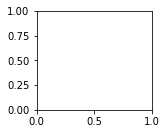

In [ ]:

# invert_normalization = torchvision.transforms.Compose([
#          torchvision.transforms.Normalize(mean = [0, 0, 0], std = 1/CIFAR100_STD),
#          torchvision.transforms.Normalize(mean = -1*CIFAR100_MEAN, std = [1,1,1])])

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


import matplotlib.pyplot as plt
model.eval()

def batchplot(batch_show,image):
# How many images from the batch will you show?
    invert_normalization = torchvision.transforms.Compose([
        torchvision.transforms.Normalize(mean = [0, 0, 0], std = [1/0.5070751592371323, 1/0.48654887331495095, 1/0.4409178433670343]),
        torchvision.transforms.Normalize(mean = -1*[0.2673342858792401, 0.2564384629170883, 0.27615047132568404], std = [1,1,1])
    ])

    def imshow(img):
        #img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            #plt.show()

    image
    # Model reconstruction
    with torch.no_grad():
        x_hat, mean, logvar = model(image)
        z = mean + torch.exp(0.5*logvar)
        x_hat = model.decode(z)

    #print(image.size())
    #image = invert_normalization(image)
    #x_hat = invert_normalization(x_hat)
    #x.transform(invert_normalization)

    fig1=plt.figure(figsize=(17,4))
    fig1.patch.set_facecolor('white')
    for i in range(batch_show):

        plt.subplot(2,batch_show,i+1)
        imshow(invert_normalization(image[i]))
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title(classes[labels[i].item()])
        if i == 0:
            plt.ylabel('Original image')
        
        plt.subplot(2,batch_show,batch_show+ i+1)
        imshow(invert_normalization(x_hat[i]))
        plt.xticks([],[])
        plt.yticks([],[])
        if i == 0:
            plt.ylabel('Reproduced image')
    pass


dataiter = iter(test_loader)
x, labels = dataiter.next()

batch_show = 7

batchplot(batch_show,x)


Convert to python file!

In [ ]:
!jupyter nbconvert --to script VAE_CIFAR100_mix.ipynb

[NbConvertApp] Converting notebook VAE_CIFAR100_mix.ipynb to script
[NbConvertApp] Writing 20533 bytes to VAE_CIFAR100_mix.py
